In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix

## Load Train and Validation data only

In [4]:
TrainDx = pd.read_csv('../input/prerocessed-danger-nbaiot/TrainDx.csv')
TrainDy = pd.read_csv('../input/prerocessed-danger-nbaiot/TrainDy.csv')
ValDx = pd.read_csv('../input/prerocessed-danger-nbaiot/ValDx.csv')
ValDy = pd.read_csv('../input/prerocessed-danger-nbaiot/ValDy.csv')

In [5]:
TotalTrainDx = pd.concat([TrainDx, ValDx], axis=0) 
TotalTrainDy = pd.concat([TrainDy, ValDy], axis=0)

## Model tuning

In [17]:
params = {
    'learning_rate':[0.10, 0.20, 0.30],
    'max_depth':[3 ,4, 5],
    'min_child_weight':[3,5,7],
    'gamma':[0.1, 0.2, 0.3],
    'alpha':[0.01, 0.03, 0.06],
    'n_estimators': [20,40, 60, 80]
}

In [18]:
xg = xgb.XGBClassifier()

In [26]:
rf_grid = RandomizedSearchCV(estimator = xg, 
                       param_distributions = params,
                       verbose=2,
                       n_jobs = -1,
                       cv = 5, n_iter = 50)

In [27]:
rf_grid.fit(TotalTrainDx, TotalTrainDy)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'alpha': [0.01, 0.03, 0.06],
                                        'gamma': [0.1, 0.2, 0.3],
                                        'learning_rate': [0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [3, 5, 7],
                                        'n_estimators': [20, 40, 60, 80]},
                   verbose=2)

[CV] END alpha=0.06, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=20; total time=  10.8s
[CV] END alpha=0.06, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=20; total time=  11.2s
[CV] END alpha=0.06, gamma=0.3, learning_rate=0.2, max_depth=5, min_child_weight=7, n_estimators=20; total time=  10.7s
[CV] END alpha=0.03, gamma=0.2, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=20; total time=  10.6s
[CV] END alpha=0.01, gamma=0.3, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=20; total time=  10.8s
[CV] END alpha=0.01, gamma=0.1, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=20; total time=  10.2s
[CV] END alpha=0.06, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=80; total time=  21.7s
[CV] END alpha=0.06, gamma=0.1, learning_rate=0.3, max_depth=4, min_child_weight=7, n_estimators=80; total time=  21.7s
[CV] END alpha=0.03, gamma=0.2, learning

In [28]:
rf_grid.best_params_

{'n_estimators': 80,
 'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.3,
 'gamma': 0.3,
 'alpha': 0.06}

In [29]:
best_model = rf_grid.best_estimator_

In [39]:
ValPreds = best_model.predict(ValDx)

In [40]:
metrics.accuracy_score(ValDy, ValPreds)

0.9999577137218972

## Test accuracy

In [38]:
TestDx = pd.read_csv('../input/prerocessed-danger-nbaiot/TestDx.csv')
TestDy = pd.read_csv('../input/prerocessed-danger-nbaiot/TestDy.csv')

In [41]:
TestPreds = best_model.predict(TestDx)
metrics.accuracy_score(TestDy, TestPreds)

0.9998289754974511

## Confusion Matrix

In [47]:
cm = pd.DataFrame(confusion_matrix(confusion_matrix(TestPreds, TestDy, labels=[0,1])))
cm

,0,1
0,153903,46
1,6,150095


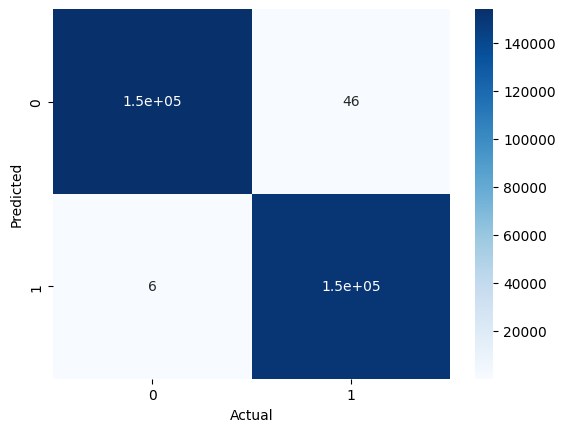

In [54]:
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Actual')
plt.ylabel('Predicted');

In [73]:
def recall(type, TestPreds, TestDy, labels):
    confMat = confusion_matrix(TestPreds, TestDy, labels=labels)
    true = confMat[type][type]
    total = 0
    for i in range(len(labels)):
        total += confMat[i][type]
    return true/total

def precision(type, TestPreds, TestDy, labels):
    confMat = confusion_matrix(TestPreds, TestDy, labels=labels)
    true = confMat[type][type]
    total = 0
    for i in range(len(labels)):
        total += confMat[type][i]
    return true/total

def specificity(type, TestPreds, TestDy, labels):
    confMat = confusion_matrix(TestPreds, TestDy, labels=labels)
    true = 0
    for i in range(len(labels)):
        if(i==type):
            continue;
        true += confMat[i][i]
    total = 0
    for j in range(len(labels)):
        if(j==type):
            continue
        for i in range(len(labels)):
            total += confMat[i][j]
    return true/total

In [68]:
for i in range(len(labels)):
    print('recall of class '+str(i)+': '+str(recall(i, TestPreds, TestDy, [0,1])))

recall of class 0: 0.9999610159249946
recall of class 1: 0.9996936213292839


In [70]:
for i in range(len(labels)):
    print('precision of class '+str(i)+': '+str(precision(i, TestPreds, TestDy, [0,1])))

precision of class 0: 0.9997011997479684
precision of class 1: 0.9999600269152105


In [74]:
for i in range(len(labels)):
    print('specificity of class '+str(i)+': '+str(specificity(i, TestPreds, TestDy, [0,1])))

specificity of class 0: 0.9996936213292839
specificity of class 1: 0.9999610159249946


## Accuracy analysis

In [77]:
def tellAcc(x, y):
    return metrics.accuracy_score(y, best_model.predict(x))

In [88]:
acc_card = []

In [89]:
acc_card.append(tellAcc(TrainDx, TrainDy))

In [90]:
acc_card.append(tellAcc(ValDx, ValDy))

In [91]:
acc_card.append(tellAcc(TestDx, TestDy))

In [92]:
acc_card

[0.9999597271109035, 0.9999577137218972, 0.9998289754974511]

In [1]:
# Create a list of indices for the x-axis
indices = range(len(acc_card))
# Create the bar graph
bars = plt.bar(indices, acc_card)
# Optionally, you can set the labels for the x-axis to be something other than the indices
labels = ['Train', 'Val', 'Test']
plt.xticks(indices, labels)
# Labeling the axes
plt.xlabel('Datasets')
plt.ylabel('Accuracies')

# Giving a title to the graph
plt.title('Accuracies for XG boost')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval, '{:.10f}'.format(yval), va='bottom') # va: vertical alignment
plt.show()

NameError: name 'acc_card' is not defined

## Saving the model

In [107]:
import pickle

In [108]:
with open('XGDanger.pkl', 'wb') as file:
    pickle.dump(best_model, file)